In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import random_split, DataLoader
import time
from torchvision.models import alexnet
from torch.optim import lr_scheduler  # Import this at the top of your script
import torch.nn.functional as F


In [16]:


# Define transformations for training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5),   # Normalize with mean and std for each channel
                         (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# Check class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Example of how to iterate through the dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f"Loaded CIFAR-10 training batch - Images shape: {images.shape}, Labels shape: {labels.shape}")


Files already downloaded and verified
Files already downloaded and verified
Loaded CIFAR-10 training batch - Images shape: torch.Size([32, 3, 32, 32]), Labels shape: torch.Size([32])


In [17]:
# Define the split ratio
val_ratio = 0.5  # Adjust this value as needed (e.g., 0.5 for a 50-50 split)

# Calculate the sizes for validation and test sets
test_size = len(testset)
val_size = int(test_size * val_ratio)
final_test_size = test_size - val_size

# Perform the split
val_set, final_test_set = random_split(testset, [val_size, final_test_size])

# Define DataLoaders for validation and final test sets
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(final_test_set, batch_size=32, shuffle=False, num_workers=2)

print(f"Validation set size: {len(val_set)}, Final test set size: {len(final_test_set)}")

Validation set size: 5000, Final test set size: 5000


In [18]:
# Checking for Mac M1 GP
if torch.backends.mps.is_available():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(device)
else:
   print("MPS is not available.")

mps


In [19]:
# Function to plot learning curves
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies,title=""):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss curves
    plt.figure()
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title+" "+'Loss Curve')
    plt.legend()
    plt.show()
    
    # Plot accuracy curves
    plt.figure()
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(title+" "+'Accuracy Curve')
    plt.legend()
    plt.show()

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)  # Adjust input size as needed based on pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 6 * 6)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track losses for learning curve
train_losses_simplecnn = []
val_losses_simplecnn = []
train_accuracies_simplecnn=[]
val_accuracies_simplecnn=[]

for epoch in range(10):  # Number of epochs
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    train_losses_simplecnn.append(epoch_loss)
    train_accuracies_simplecnn.append(epoch_accuracy)
    print(f"Epoch {epoch + 1}/10, Loss: {epoch_loss:.6f}, Accuracy: {epoch_accuracy:.3f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses_simplecnn.append(val_loss)
    val_accuracies_simplecnn.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.6f}, Accuracy: {val_accuracy:.2f}%")


Epoch 1/10, Loss: 1.335031, Accuracy: 51.876%
Validation Loss: 1.106943, Accuracy: 60.76%
Epoch 2/10, Loss: 0.973851, Accuracy: 65.856%
Validation Loss: 0.939588, Accuracy: 67.16%
Epoch 3/10, Loss: 0.823269, Accuracy: 71.262%
Validation Loss: 0.907896, Accuracy: 68.82%
Epoch 4/10, Loss: 0.715684, Accuracy: 74.890%
Validation Loss: 0.884620, Accuracy: 70.18%
Epoch 5/10, Loss: 0.628621, Accuracy: 77.962%
Validation Loss: 0.854249, Accuracy: 71.56%
Epoch 6/10, Loss: 0.556103, Accuracy: 80.396%
Validation Loss: 0.911802, Accuracy: 70.62%
Epoch 7/10, Loss: 0.488641, Accuracy: 82.846%
Validation Loss: 0.906708, Accuracy: 71.58%
Epoch 8/10, Loss: 0.429706, Accuracy: 84.846%
Validation Loss: 0.996218, Accuracy: 70.70%
Epoch 9/10, Loss: 0.379320, Accuracy: 86.504%
Validation Loss: 0.996081, Accuracy: 71.26%
Epoch 10/10, Loss: 0.328015, Accuracy: 88.328%
Validation Loss: 1.098556, Accuracy: 70.76%


Test Set Accuracy: 71.18%


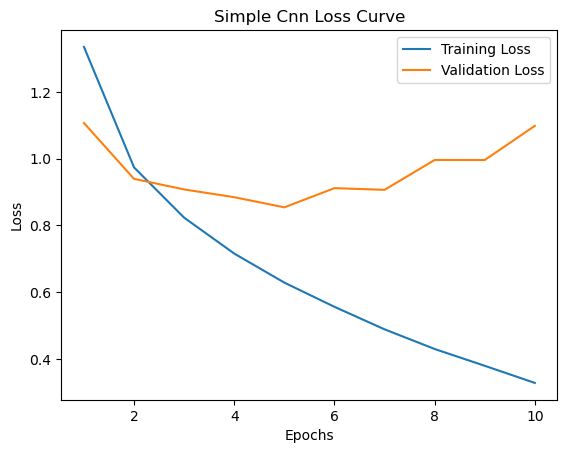

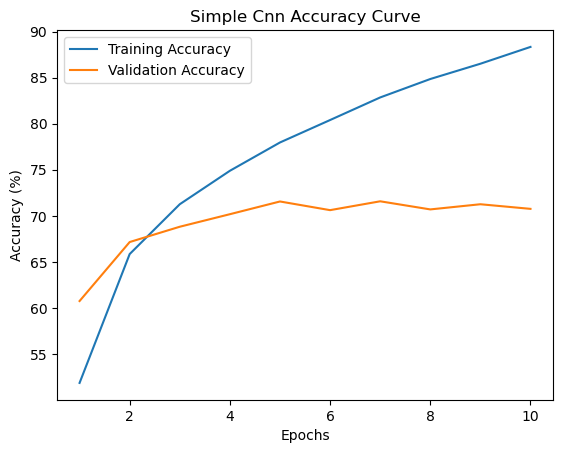

In [21]:
# Test set evaluation
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Set Accuracy: {test_accuracy:.2f}%")


plot_learning_curves(train_losses_simplecnn, val_losses_simplecnn, train_accuracies_simplecnn, val_accuracies_simplecnn,title='Simple Cnn')

# Resnet18 With SGD optimizer

In [10]:
#SGD Resnet18

# Data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(final_test_set, batch_size=64, shuffle=False, num_workers=2)

# Define device (use GPU if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Initialize ResNet-18 model (without pretrained weights)
model = models.resnet18(weights=None)  # No pre-trained weights
model.fc = nn.Linear(model.fc.in_features, 10)  # Modify the final layer to output 10 classes (for CIFAR-10)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
train_accuracies_sgd, val_accuracies_sgd = [], []
train_losses_sgd, val_losses_sgd = [], []

# Training function with learning curve data
def train_validate_resnet_sgd(model, trainloader, valloader, criterion, optimizer, epochs=10):
  
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses_sgd.append(train_loss)
        train_accuracies_sgd.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(valloader)
        val_accuracy = 100 * correct / total
        val_losses_sgd.append(val_loss)
        val_accuracies_sgd.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
   

# Train and validate the model
train_validate_resnet_sgd(model, trainloader, valloader, criterion, optimizer, epochs=10)



Epoch 1/10, Train Loss: 1.9566, Train Accuracy: 29.09%, Val Loss: 1.6927, Val Accuracy: 38.26%
Epoch 2/10, Train Loss: 1.6002, Train Accuracy: 41.97%, Val Loss: 1.5146, Val Accuracy: 44.56%
Epoch 3/10, Train Loss: 1.4456, Train Accuracy: 47.55%, Val Loss: 1.4212, Val Accuracy: 48.40%
Epoch 4/10, Train Loss: 1.3446, Train Accuracy: 51.51%, Val Loss: 1.3602, Val Accuracy: 50.70%
Epoch 5/10, Train Loss: 1.2566, Train Accuracy: 55.06%, Val Loss: 1.3178, Val Accuracy: 52.60%
Epoch 6/10, Train Loss: 1.1872, Train Accuracy: 57.63%, Val Loss: 1.2917, Val Accuracy: 53.62%
Epoch 7/10, Train Loss: 1.1162, Train Accuracy: 60.38%, Val Loss: 1.2698, Val Accuracy: 54.56%
Epoch 8/10, Train Loss: 1.0528, Train Accuracy: 62.67%, Val Loss: 1.2521, Val Accuracy: 54.78%
Epoch 9/10, Train Loss: 0.9959, Train Accuracy: 65.04%, Val Loss: 1.2493, Val Accuracy: 55.52%
Epoch 10/10, Train Loss: 0.9371, Train Accuracy: 67.22%, Val Loss: 1.2297, Val Accuracy: 55.98%


Test Loss: 1.2306919422330735, Accuracy: 56.2%


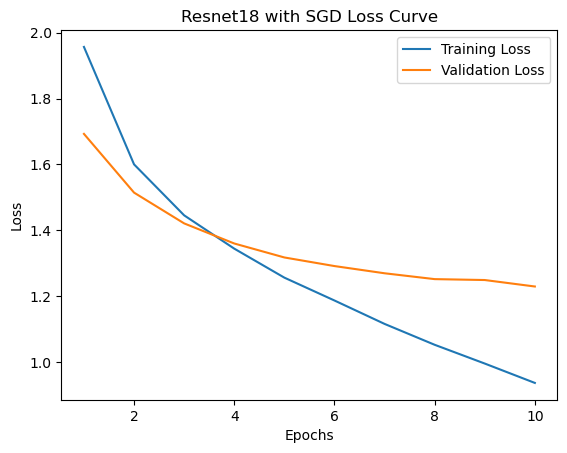

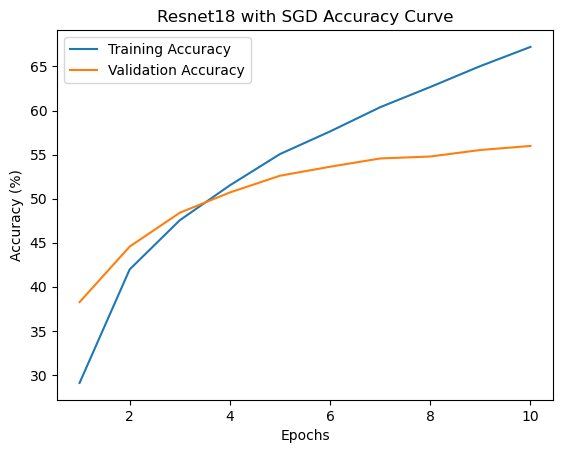

In [14]:
# Testing function
def test_validate_resnet_sgd(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss / len(test_loader)}, Accuracy: {accuracy}%")


# Evaluate on test set
test_validate_resnet_sgd(model, testloader, criterion)


plot_learning_curves(train_losses_sgd, val_losses_sgd, train_accuracies_sgd, val_accuracies_sgd,'Resnet18 with SGD')


# CNN Resnet18 with adam optimiser

In [22]:
# adam Resnet18

# Data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(final_test_set, batch_size=64, shuffle=False, num_workers=2)

# Define device (use GPU if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Initialize ResNet-18 model (without pretrained weights)
model = models.resnet18(weights=None)  # No pre-trained weights
model.fc = nn.Linear(model.fc.in_features, 10)  # Modify the final layer to output 10 classes (for CIFAR-10)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses_adam = []
val_losses_adam = []
val_accuracies_adam = []
train_accuracies_adam = []

# Training function
# Training function with accuracy
def train_validate_resnet_adam(model, trainloader, criterion, optimizer, epochs=10):
    

    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses_adam.append(epoch_loss)
        train_accuracies_adam.append(epoch_accuracy)

        # Validate at the end of each epoch
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(valloader)
        val_accuracy = 100 * val_correct / val_total
        val_losses_adam.append(val_loss)
        val_accuracies_adam.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}%, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%")
    


# Train and validate the model
train_validate_resnet_adam(model, trainloader, criterion, optimizer, epochs=10)




Epoch 1/10, Train Loss: 1.3730090691915253, Train Accuracy: 51.004%, Val Loss: 1.3046071363400809, Val Accuracy: 55.18%
Epoch 2/10, Train Loss: 0.9711290250348923, Train Accuracy: 65.892%, Val Loss: 1.0491500436505186, Val Accuracy: 63.76%
Epoch 3/10, Train Loss: 0.7968791250682548, Train Accuracy: 72.228%, Val Loss: 0.8530161954179595, Val Accuracy: 70.0%
Epoch 4/10, Train Loss: 0.6771422417648613, Train Accuracy: 76.66%, Val Loss: 0.7839652356467669, Val Accuracy: 73.48%
Epoch 5/10, Train Loss: 0.5759206044933071, Train Accuracy: 79.868%, Val Loss: 0.7703839057608496, Val Accuracy: 74.38%
Epoch 6/10, Train Loss: 0.48285286582034564, Train Accuracy: 83.03%, Val Loss: 0.813085493407672, Val Accuracy: 73.54%
Epoch 7/10, Train Loss: 0.3990987289668349, Train Accuracy: 86.296%, Val Loss: 0.799952141469038, Val Accuracy: 73.68%
Epoch 8/10, Train Loss: 0.3213628216758561, Train Accuracy: 88.87%, Val Loss: 0.7854923224901851, Val Accuracy: 76.04%
Epoch 9/10, Train Loss: 0.2551850257131755, T

Test Loss: 0.8813960246647461, Accuracy: 76.06%


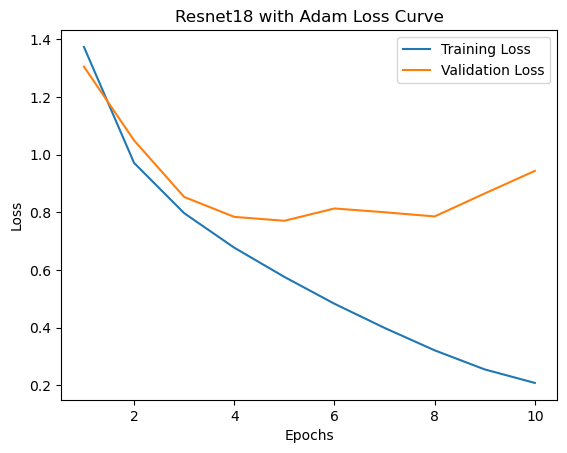

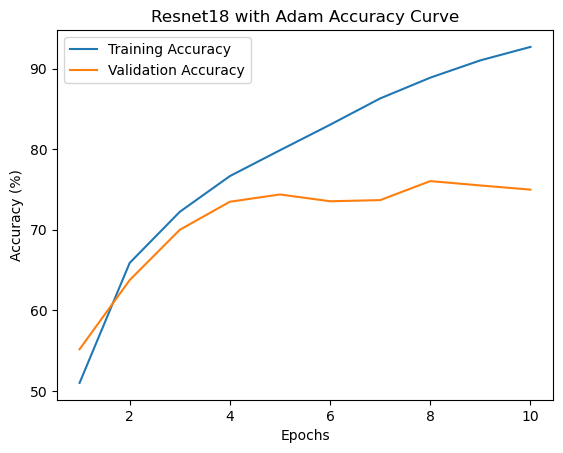

In [23]:
# Test function
def test_validate_resnet_adam(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss / len(testloader)}, Accuracy: {accuracy}%")
test_validate_resnet_adam(model, testloader, criterion)



plot_learning_curves(train_losses_adam, val_losses_adam, train_accuracies_adam, val_accuracies_adam,"Resnet18 with Adam")

# Resnet18 with adam optimiser and  lr=0.01, weight_decay=1e-4


In [ ]:
# adam baseline weights default optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)


# Data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(final_test_set, batch_size=64, shuffle=False, num_workers=2)

# Define device (use GPU if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Initialize ResNet-18 model (without pretrained weights)
model = models.resnet18(weights=None) # No pre-trained weights
model.fc = nn.Linear(model.fc.in_features, 10)  # Modify the final layer to output 10 classes (for CIFAR-10)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses_lrchange = []
val_losses_lrchange = []
val_accuracies_lrchange = []
train_accuracies_lrchange = []

def train_validate_resnet_adam_lr_change(model, trainloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses_lrchange.append(epoch_loss)
        train_accuracies_lrchange.append(epoch_accuracy)

        # Validate at the end of each epoch
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(valloader)
        val_accuracy = 100 * val_correct / val_total
        val_losses_lrchange.append(val_loss)
        val_accuracies_lrchange.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}%, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%")

# Train and validate the model
train_validate_resnet_adam_lr_change(model, trainloader, criterion, optimizer, epochs=10)




Epoch 1/10, Train Loss: 1.7062206437520664, Train Accuracy: 39.25%, Val Loss: 1.5299086012417757, Val Accuracy: 45.44%
Epoch 2/10, Train Loss: 1.2771492713247723, Train Accuracy: 54.188%, Val Loss: 1.163224316096004, Val Accuracy: 59.1%
Epoch 3/10, Train Loss: 1.0883127410545983, Train Accuracy: 61.784%, Val Loss: 1.1705679350261446, Val Accuracy: 57.9%
Epoch 4/10, Train Loss: 0.9988079853070057, Train Accuracy: 65.156%, Val Loss: 0.9769937712934953, Val Accuracy: 65.3%
Epoch 5/10, Train Loss: 0.9417041089681103, Train Accuracy: 67.126%, Val Loss: 0.9198574008820932, Val Accuracy: 68.18%
Epoch 6/10, Train Loss: 0.9023528682911183, Train Accuracy: 68.596%, Val Loss: 1.0072414595869523, Val Accuracy: 65.08%
Epoch 7/10, Train Loss: 0.8783825520816666, Train Accuracy: 69.522%, Val Loss: 0.9208918394921701, Val Accuracy: 67.92%
Epoch 8/10, Train Loss: 0.855559780088532, Train Accuracy: 70.362%, Val Loss: 0.9700649010984204, Val Accuracy: 66.0%
Epoch 9/10, Train Loss: 0.84354519432463, Train

Test Loss: 0.8937591457668739, Accuracy: 69.14%


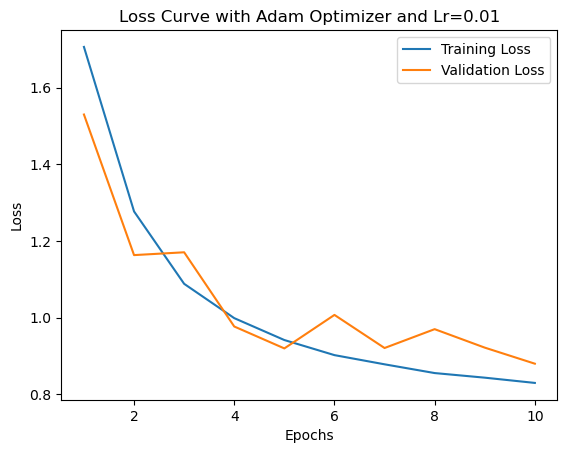

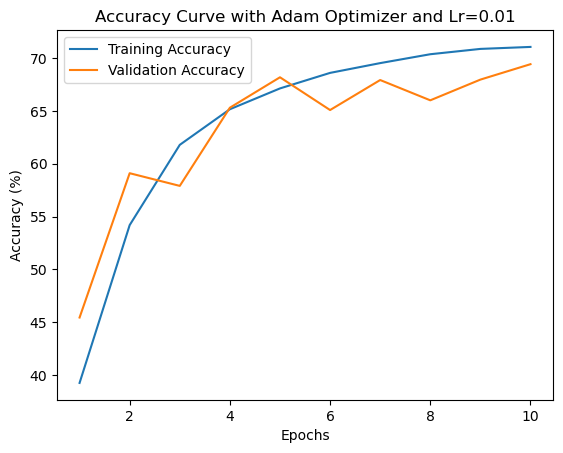

In [ ]:
def test_validate_resnet_adam_lr_change(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss / len(testloader)}, Accuracy: {accuracy}%")
test_validate_resnet_adam_lr_change(model, testloader, criterion)


plot_learning_curves(train_losses_lrchange, val_losses_lrchange, train_accuracies_lrchange, val_accuracies_lrchange, "with adam optimizer and LR=0.01")

To improve the model's performance, particularly the validation accuracy, we can perform hyperparameter optimization. Here are some steps to consider:

Learning Rate Optimization: The learning rate might be too high or too low. Try a learning rate scheduler or a different learning rate.
Optimizer Choices: Experiment with different optimizers like SGD with momentum, RMSprop, or AdamW.
Data Augmentation: Apply more data augmentations to the training data to help the model generalize better.
Batch Size Tuning: Try different batch sizes (smaller or larger) to see their effect on convergence.
Model Regularization:
Weight Decay: Add weight decay to the optimizer.
Dropout: Add dropout layers to prevent overfitting.
Epochs and Early Stopping: Train for more epochs and use early stopping based on validation accuracy.
Here's a revised code with some of these optimizations:

Epoch 1/10, Train Loss: 0.0024580155334816803, Train Accuracy: 99.958%, Val Loss: 1.288977924404265, Val Accuracy: 78.32%
Learning rate: 1e-05
Epoch 2/10, Train Loss: 0.0021433509918122704, Train Accuracy: 99.974%, Val Loss: 1.2929709180246425, Val Accuracy: 78.66%
Learning rate: 1e-05
Epoch 3/10, Train Loss: 0.0018591385417370883, Train Accuracy: 99.968%, Val Loss: 1.2739348864253563, Val Accuracy: 78.76%
Learning rate: 1e-05
Epoch 4/10, Train Loss: 0.0016026950523113522, Train Accuracy: 99.976%, Val Loss: 1.2793706568736065, Val Accuracy: 78.44%
Learning rate: 1e-05
Epoch 5/10, Train Loss: 0.0014677968545146706, Train Accuracy: 99.98%, Val Loss: 1.3122004089476187, Val Accuracy: 78.04%
Learning rate: 1.0000000000000002e-06
Epoch 6/10, Train Loss: 0.0013128736811914676, Train Accuracy: 99.982%, Val Loss: 1.313337872299967, Val Accuracy: 78.12%
Learning rate: 1.0000000000000002e-06
Epoch 7/10, Train Loss: 0.0012925816057121878, Train Accuracy: 99.988%, Val Loss: 1.3227122056333325, Val

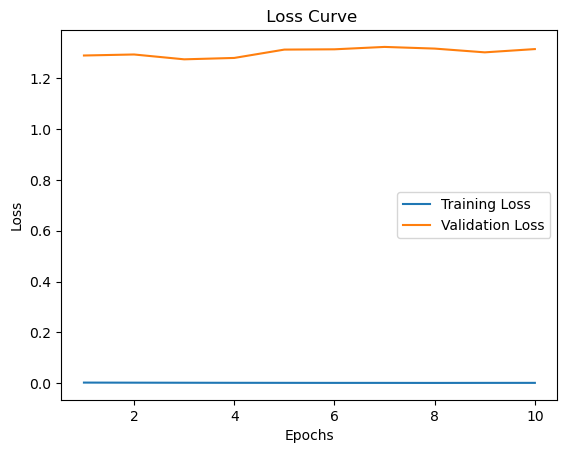

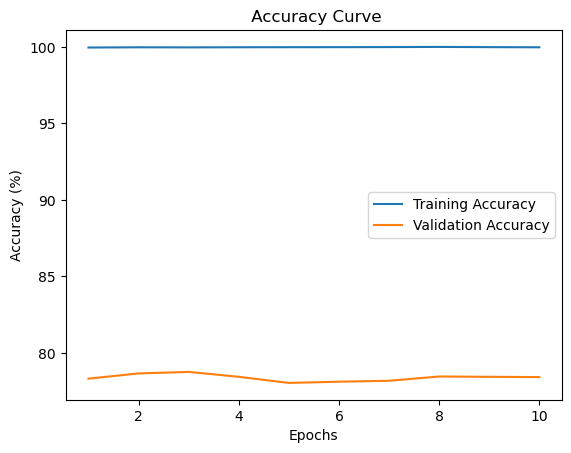

In [27]:
from torch.optim.lr_scheduler import StepLR
# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)  # Reduces LR by a factor of 0.1 every 5 epochs

train_losses_with_schedule = []
val_losses_with_schedule = []
val_accuracies_with_schedule = []
train_accuracies_with_schedule = []

def train_validate_resnet_with_scheduler(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=10):
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses_with_schedule.append(epoch_loss)
        train_accuracies_with_schedule.append(epoch_accuracy)

        # Validate at the end of each epoch
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(valloader)
        val_accuracy = 100 * val_correct / val_total
        val_losses_with_schedule.append(val_loss)
        val_accuracies_with_schedule.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}%, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%")
        
        # Step the scheduler
        scheduler.step()
        print(f"Learning rate: {scheduler.get_last_lr()[0]}")
def test_validate_resnet_adam_lr_scheluder(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss / len(testloader)}, Accuracy: {accuracy}%")


# Train and validate the model
train_validate_resnet_with_scheduler(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=10)

# Test function remains the same
test_validate_resnet_adam_lr_scheluder(model, testloader, criterion)

# Plot learning curves
plot_learning_curves(train_losses_with_schedule, val_losses_with_schedule, train_accuracies_with_schedule, val_accuracies_with_schedule)

To improve the performance of your ResNet-18 model on CIFAR-10, we can optimize hyperparameters such as the learning rate, batch size, and optimizer parameters. Below are some strategies for hyperparameter optimization:

1. Learning Rate Tuning
The learning rate significantly impacts convergence. We could try different learning rates using a range or learning rate scheduler.

2. Batch Size
Smaller batch sizes may improve generalization, while larger batch sizes might speed up training.

3. Optimizer and Weight Decay
Experimenting with weight decay (L2 regularization) can help reduce overfitting. The Adam optimizer itself can have tunable parameters like betas.

4. Scheduler
A learning rate scheduler can dynamically adjust the learning rate during training, such as StepLR, ReduceLROnPlateau, or CosineAnnealingLR.

5. Data Augmentation
Enhance the input data with augmentations like random crops, flips, and normalization.

Let's start by experimenting with a few options programmatically.

1. Implement Learning Rate Search and Weight Decay
Below is a code snippet that incorporates a learning rate scheduler and weight decay:

# Alexnet

Epoch 1/10, Train Loss: 1.5996506671466486, Train Accuracy: 39.604%, Validation Loss: 1.2711605425852879, Validation Accuracy: 54.32%
Epoch 2/10, Train Loss: 1.1667895365096723, Train Accuracy: 57.976%, Validation Loss: 1.031422523935889, Validation Accuracy: 63.38%
Epoch 3/10, Train Loss: 0.9863764610131989, Train Accuracy: 65.482%, Validation Loss: 0.9446200398123188, Validation Accuracy: 66.96%
Epoch 4/10, Train Loss: 0.8669426239969785, Train Accuracy: 69.682%, Validation Loss: 0.8286192886009338, Validation Accuracy: 71.02%
Epoch 5/10, Train Loss: 0.7802179616582973, Train Accuracy: 72.76%, Validation Loss: 0.7894343139639326, Validation Accuracy: 72.86%
Epoch 6/10, Train Loss: 0.7074026532109131, Train Accuracy: 75.34%, Validation Loss: 0.779417087697679, Validation Accuracy: 73.4%
Epoch 7/10, Train Loss: 0.6615660197061041, Train Accuracy: 76.924%, Validation Loss: 0.7671929941435528, Validation Accuracy: 74.66%
Epoch 8/10, Train Loss: 0.6098303641275982, Train Accuracy: 78.776%

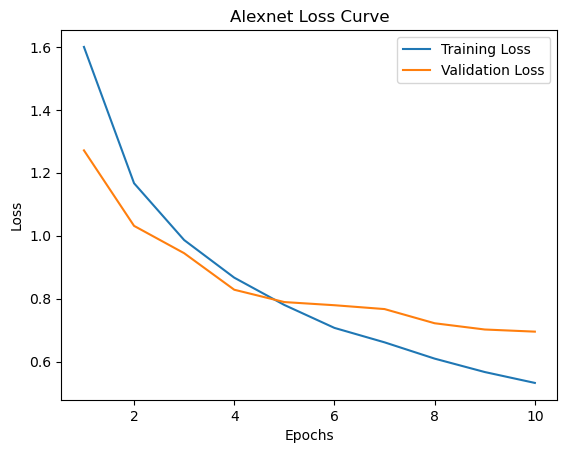

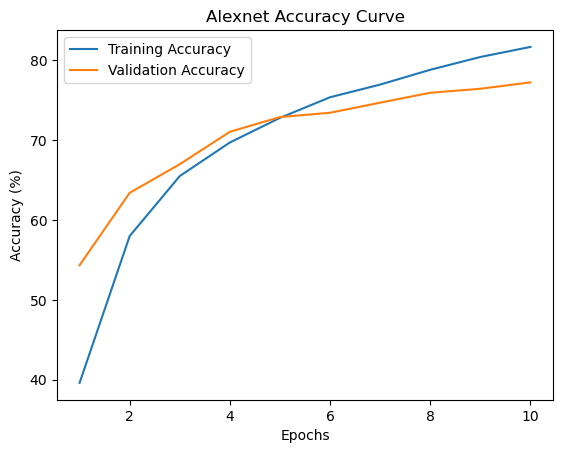

In [34]:
class AlexNetModified(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetModified, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Changed kernel size and stride
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),  # Adjusted based on final feature map size (4x4)
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the modified AlexNet
model_alexnet = AlexNetModified(num_classes=10).to(device)



device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load AlexNet with pre-trained weights if needed
#model_alexnet = models.alexnet(weights=None)  # Use pretrained weights

# Modify the classifier to fit CIFAR-10 (10 classes)
model_alexnet.classifier[6] = nn.Linear(model_alexnet.classifier[6].in_features, 10)

# Move model to the device
model_alexnet = model_alexnet.to(device)

criterion_alexnet = nn.CrossEntropyLoss()
optimizer_alexnet = optim.Adam(model_alexnet.parameters(), lr=0.001)

train_losses_alexnet = []
val_losses_alexnet = []
val_accuracies_alexnet= []
train_accuracies_alexnet = []

def train_alexnet(model, trainloader, criterion, optimizer, valloader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses_alexnet.append(epoch_loss)
        train_accuracies_alexnet.append(epoch_accuracy)

        # Validate after each epoch
        val_loss, val_accuracy = validate_alexnet(model, valloader, criterion)
        val_losses_alexnet.append(val_loss)
        val_accuracies_alexnet.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}%, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%")

        

def validate_alexnet(model, valloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    accuracy = 100 * correct / total
    return val_loss, accuracy


# Train the AlexNet model
train_alexnet(model_alexnet, trainloader, criterion_alexnet, optimizer_alexnet, val_loader, epochs=10)


plot_learning_curves(train_losses_alexnet , val_losses_alexnet , train_accuracies_alexnet , val_accuracies_alexnet,'Alexnet')




In [35]:
def test_alexnet(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")
    return test_loss, test_accuracy
    # Evaluate the model on the test set
test_loss, test_accuracy = test_alexnet(model_alexnet, test_loader, criterion_alexnet)


Test Loss: 0.695609006722262, Test Accuracy: 77.52%


# Mobilenet_v2

Epoch 1/10, Train Loss: 1.8911, Train Accuracy: 29.85%, Validation Loss: 1.6031, Validation Accuracy: 40.66%
Epoch 2/10, Train Loss: 1.5386, Train Accuracy: 43.75%, Validation Loss: 1.4059, Validation Accuracy: 48.68%
Epoch 3/10, Train Loss: 1.3710, Train Accuracy: 50.84%, Validation Loss: 1.3259, Validation Accuracy: 52.00%
Epoch 4/10, Train Loss: 1.2335, Train Accuracy: 56.39%, Validation Loss: 1.2052, Validation Accuracy: 56.26%
Epoch 5/10, Train Loss: 1.1133, Train Accuracy: 61.09%, Validation Loss: 1.0917, Validation Accuracy: 61.26%
Epoch 6/10, Train Loss: 1.0166, Train Accuracy: 64.63%, Validation Loss: 1.0024, Validation Accuracy: 65.20%
Epoch 7/10, Train Loss: 0.9305, Train Accuracy: 67.75%, Validation Loss: 0.9368, Validation Accuracy: 67.48%
Epoch 8/10, Train Loss: 0.8610, Train Accuracy: 70.47%, Validation Loss: 0.8836, Validation Accuracy: 69.56%
Epoch 9/10, Train Loss: 0.7979, Train Accuracy: 72.38%, Validation Loss: 0.8806, Validation Accuracy: 70.02%
Epoch 10/10, Train 

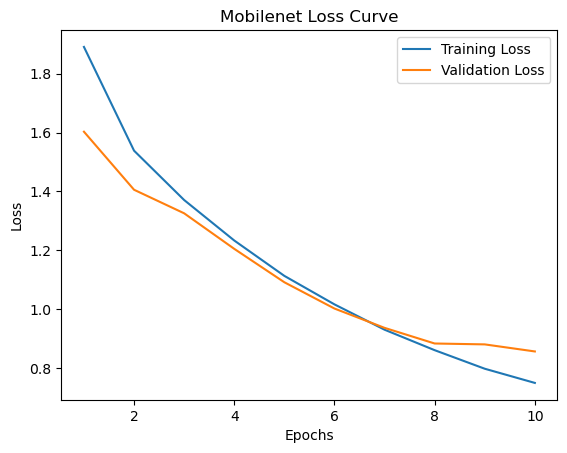

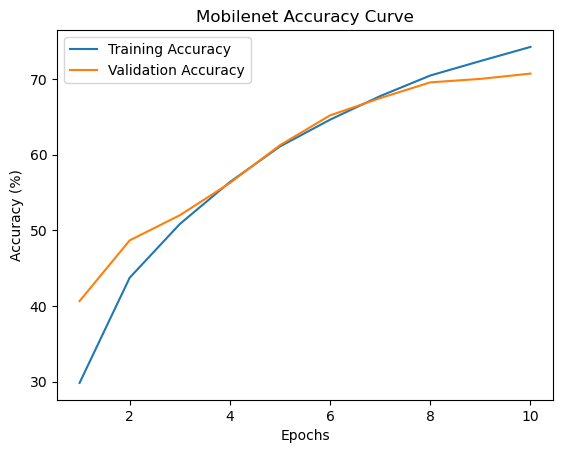

In [32]:
from torchvision.models import mobilenet_v2

# Load the pretrained MobileNetV2 model
model_mobilenet = mobilenet_v2(weights=None)  # Use pretrained weights

# Modify the classifier to fit CIFAR-10 (10 classes)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, 10)

# Move the model to the available device
model_mobilenet = model_mobilenet.to(device)

# Loss function
criterion_mobilenet = nn.CrossEntropyLoss()

# Optimizer
optimizer_mobilenet = optim.Adam(model_mobilenet.parameters(), lr=0.001)


# Lists to store the loss and accuracy for plotting the learning curve
train_losses_mobilenet = []
train_accuracies_mobilenet = []
val_losses_mobilenet = []
val_accuracies_mobilenet = []

def train_mobilenet(model, trainloader, criterion, optimizer, valloader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses_mobilenet.append(epoch_loss)
        train_accuracies_mobilenet.append(epoch_accuracy)

        # Validate after each epoch
        val_loss, val_accuracy = validate_mobilenet(model, valloader, criterion)
        val_losses_mobilenet.append(val_loss)
        val_accuracies_mobilenet.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        

def validate_mobilenet(model, valloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    accuracy = 100 * correct / total
    return val_loss, accuracy



# Train MobileNet
train_mobilenet(model_mobilenet, trainloader, criterion_mobilenet, optimizer_mobilenet, val_loader, epochs=10)

plot_learning_curves(train_losses_mobilenet , val_losses_mobilenet , train_accuracies_mobilenet , val_accuracies_mobilenet,'Mobilenet')


In [36]:
test_loss, test_accuracy = test_alexnet(model_mobilenet, test_loader, criterion_mobilenet)

Test Loss: 0.8594847171549584, Test Accuracy: 70.14%
